Rulare algoritm genetic cu 1000 stații și populație de 100...
gen	nevals	min    	avg    
0  	100   	1.33369	1.40064
1  	48    	1.33369	1.37386
2  	55    	1.32041	1.35823
3  	60    	1.28197	1.34476
4  	48    	1.28197	1.33018
5  	50    	1.27922	1.31759
6  	42    	1.2734 	1.30546
7  	49    	1.25425	1.29326
8  	48    	1.25425	1.28463
9  	59    	1.24829	1.27647
10 	53    	1.24154	1.26756
11 	49    	1.2396 	1.26106
12 	57    	1.22386	1.25442
13 	56    	1.2216 	1.24857
14 	52    	1.2216 	1.24407
15 	47    	1.20374	1.23742
16 	59    	1.20374	1.2315 
17 	58    	1.18838	1.22408
18 	51    	1.18838	1.21406
19 	54    	1.18467	1.20787
20 	49    	1.1846 	1.1996 
21 	49    	1.17509	1.1943 
22 	58    	1.17225	1.18957
23 	52    	1.16899	1.1838 
24 	57    	1.16316	1.1803 
25 	55    	1.15832	1.17604
26 	43    	1.14698	1.1708 
27 	59    	1.14698	1.16658
28 	46    	1.14152	1.15992
29 	38    	1.14105	1.1551 
30 	35    	1.13736	1.15225
31 	53    	1.12964	1.14837
32 	53    	1.12964	1.14499
33 	59    	1.12401	1

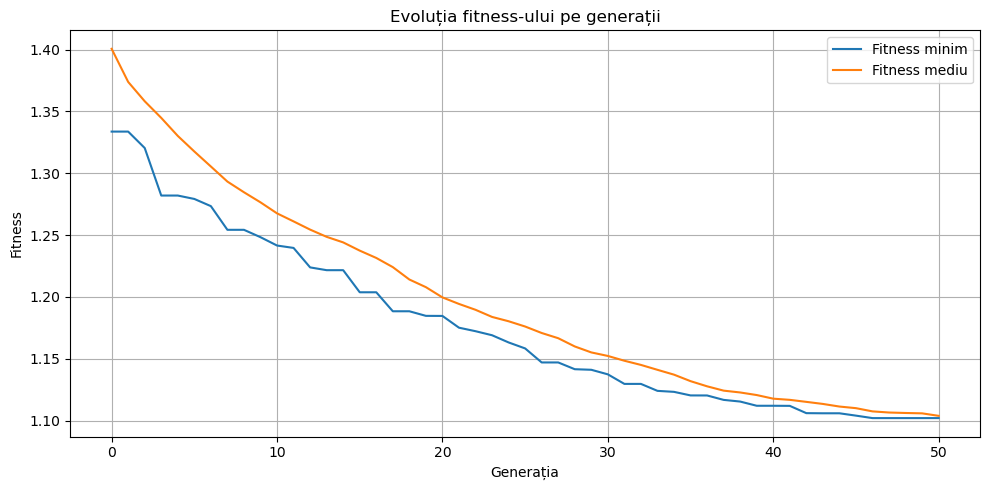

In [14]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from deap import base, creator, tools, algorithms

# Citire fișier
cale_fisier = r"C:\Users\Administrator\Desktop\Master\Modul 4\Metode de inspiratie biologica in inteligenta artificiala-S1\Proiect MIBIA\COD\lte_data.csv"
df = pd.read_csv(cale_fisier)
df.columns = ["type", "mcc", "net", "area", "cell", "unit", "lon", "lat", "range", "samples", "changeable", "created", "updated", "averageSignal"]

# Selectăm aleator 1000 de stații
df_sampled = df.sample(n=1000, random_state=42).reset_index(drop=True)

# Funcție fitness
def define_fitness(stations, grid_points):
    def fitness(individual):
        active_stations = stations[np.array(individual) == 1]
        if len(active_stations) == 0:
            return (1e6,)  # Penalizare dacă nicio stație nu e activă

        total_uncovered = 0
        total_distance = 0.0

        for point in grid_points:
            dists = np.linalg.norm(active_stations[:, :2] - point, axis=1)
            in_range = dists <= active_stations[:, 2]

            if np.any(in_range):
                total_distance += np.min(dists[in_range])
            else:
                total_uncovered += 1
                total_distance += 1000  # Penalizare mare

        penalty_size = np.sum(individual) / len(individual)
        penalty_uncovered = total_uncovered / len(grid_points)
        score = total_distance / len(grid_points) + 10 * penalty_uncovered + 2 * penalty_size
        return (score,)
    return fitness

# Pregătire date
N = 1000
stations = df_sampled[["lat", "lon", "range"]].to_numpy()
lat_vals = np.linspace(stations[:, 0].min(), stations[:, 0].max(), 30)
lon_vals = np.linspace(stations[:, 1].min(), stations[:, 1].max(), 30)
grid_points = np.array([[lat, lon] for lat in lat_vals for lon in lon_vals])
fitness_func = define_fitness(stations, grid_points)

# Resetăm clasele DEAP (pentru rulări multiple)
for cls in ["FitnessMin", "Individual"]:
    if cls in creator.__dict__:
        del creator.__dict__[cls]

# Inițializare DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness_func)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Rulare algoritm genetic
pop_size = 100
num_generations = 50
pop = toolbox.population(n=pop_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

print("Rulare algoritm genetic cu 1000 stații și populație de 100...")
start = time.time()
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.05, ngen=num_generations,
                               stats=stats, halloffame=hof, verbose=True)
duration = time.time() - start

# Rezultate finale
best = hof[0]
active_count = sum(best)
fitness_final = best.fitness.values[0]

print("\nRezultate finale:")
print(f"Număr stații active: {active_count}")
print(f"Fitness final: {fitness_final:.2f}")
print(f"Durată execuție: {duration:.2f} secunde")

# Plot evoluție fitness
min_vals = log.select("min")
avg_vals = log.select("avg")

plt.figure(figsize=(10, 5))
plt.plot(min_vals, label="Fitness minim")
plt.plot(avg_vals, label="Fitness mediu")
plt.title("Evoluția fitness-ului pe generații")
plt.xlabel("Generația")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


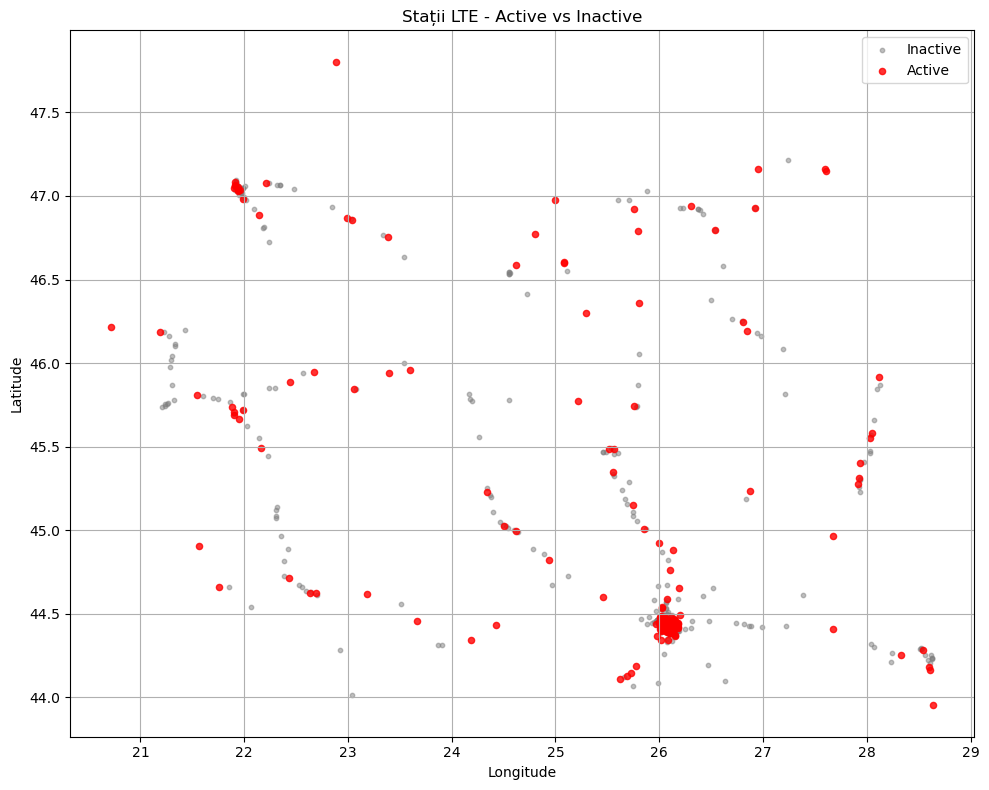

In [12]:
# Extragem stațiile active și inactive
active_mask = np.array(best) == 1
active_stations = stations[active_mask]
inactive_stations = stations[~active_mask]

# Plot stații pe hartă
plt.figure(figsize=(10, 8))
plt.scatter(inactive_stations[:, 1], inactive_stations[:, 0], c='gray', s=10, label="Inactive", alpha=0.5)
plt.scatter(active_stations[:, 1], active_stations[:, 0], c='red', s=20, label="Active", alpha=0.8)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Stații LTE - Active vs Inactive")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()